In [3]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import linregress
import requests
from datetime import datetime
from api_key import ip_api_key
import seaborn as sns
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [4]:
#setting up path and reading csv for original csv file
card_fraud_path_load = Path("merged_file.csv")
merged_df = pd.read_csv(card_fraud_path_load)
merged_df.head()

,Transaction ID,IP,City,Lat,Lng,Continent,Capital,Country,Transaction Date and Time,Transaction Amount,...,Card Expiration Date,CVV Code (Hashed or Encrypted),Transaction Response Code,Fraud Flag or Label,Previous Transactions,Transaction Source,IP Address,Device Information,User Account Information,Transaction Notes
0,0003c9a2-3e18-499f-8b1f-f6f20eecb83c,11.133.155.94,Columbus,39.97883,-82.89573,North America,"Washington, D.C.","Washington, D.C.",2021-03-28 12:02:22,4584.73,...,09/31,162753c27c8b32975a0edf5e89ab4ed8e2f06f02a182e0...,0,1,3 or more,Online,11.133.155.94,Mobile,yuvraj-22,Culpa sit eligendi vel eaque aperiam quo. Sint...
1,001538cf-4b3c-4d81-9cce-fb74fa5c6427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-06-11 15:30:47,2895.00,...,01/25,1e68ed4e3d58a51096a7feea3947f40debf1fd9246ec97...,12,0,2,Online,102.205.87.49,Desktop,ukhanna,Assumenda amet corporis consectetur asperiores...
2,0016926c-d82a-4070-a0ad-cd1416674744,210.63.242.180,Taipei City,25.05437,121.60681,Asia,Taipei,Taipei,2023-07-16 01:16:14,1492.48,...,12/31,56f4da26ed956730309fa1488611ee0f13b0ac95ebb1bc...,5,1,2,In-Person,210.63.242.180,Tablet,NaN,Officiis incidunt minima magnam. Explicabo exp...
3,001b0dd8-5d3b-401a-9093-2093b562e559,175.92.199.54,Beijing,39.90499,116.40529,Asia,Beijing,Beijing,2021-12-08 15:57:04,1077.20,...,03/25,8b6cd7c429e83373dbd412f43d7422c0c4a127d93d0f2a...,12,1,3 or more,In-Person,175.92.199.54,Tablet,NaN,Qui quam ad ipsam ab atque ipsa. Qui tempore q...
4,003014ef-45b3-4743-bc6f-adab9a91a037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-07-12 03:15:14,2470.89,...,01/30,533eb9a8909f614c351b65e6b8aba1ffc2890735ce9a8a...,12,0,3 or more,Online,205.60.134.240,Desktop,wagletushar,Deserunt fugit impedit odio molestiae reiciend...


In [5]:
merged_df=merged_df.copy()

In [6]:
#Assigning correct data types
merged_df["Lat"]=merged_df["Lat"].astype(str)
merged_df["Lng"]=merged_df["Lng"].astype(str)
merged_df["Transaction Date and Time"]=pd.to_datetime(merged_df["Transaction Date and Time"])
merged_df["Merchant Category Code (MCC)"]=merged_df["Merchant Category Code (MCC)"].astype(int)
merged_df["Card Expiration Date"]=pd.to_datetime(merged_df["Card Expiration Date"], format="%m/%d",errors="coerce")
merged_df["Transaction Response Code"]=merged_df["Transaction Response Code"].astype(str)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Transaction ID                           8000 non-null   object        
 1   IP                                       3989 non-null   object        
 2   City                                     3980 non-null   object        
 3   Lat                                      8000 non-null   object        
 4   Lng                                      8000 non-null   object        
 5   Continent                                3989 non-null   object        
 6   Capital                                  3989 non-null   object        
 7   Country                                  3989 non-null   object        
 8   Transaction Date and Time                8000 non-null   datetime64[ns]
 9   Transaction Amount                       

In [7]:
#Filtering data with flagged transxns =1
final_df=merged_df.loc[merged_df["Fraud Flag or Label"]==1]
final_df.head()


,Transaction ID,IP,City,Lat,Lng,Continent,Capital,Country,Transaction Date and Time,Transaction Amount,...,Card Expiration Date,CVV Code (Hashed or Encrypted),Transaction Response Code,Fraud Flag or Label,Previous Transactions,Transaction Source,IP Address,Device Information,User Account Information,Transaction Notes
0,0003c9a2-3e18-499f-8b1f-f6f20eecb83c,11.133.155.94,Columbus,39.97883,-82.89573,North America,"Washington, D.C.","Washington, D.C.",2021-03-28 12:02:22,4584.73,...,NaT,162753c27c8b32975a0edf5e89ab4ed8e2f06f02a182e0...,0,1,3 or more,Online,11.133.155.94,Mobile,yuvraj-22,Culpa sit eligendi vel eaque aperiam quo. Sint...
2,0016926c-d82a-4070-a0ad-cd1416674744,210.63.242.180,Taipei City,25.05437,121.60681,Asia,Taipei,Taipei,2023-07-16 01:16:14,1492.48,...,1900-12-31,56f4da26ed956730309fa1488611ee0f13b0ac95ebb1bc...,5,1,2,In-Person,210.63.242.180,Tablet,NaN,Officiis incidunt minima magnam. Explicabo exp...
3,001b0dd8-5d3b-401a-9093-2093b562e559,175.92.199.54,Beijing,39.90499,116.40529,Asia,Beijing,Beijing,2021-12-08 15:57:04,1077.20,...,1900-03-25,8b6cd7c429e83373dbd412f43d7422c0c4a127d93d0f2a...,12,1,3 or more,In-Person,175.92.199.54,Tablet,NaN,Qui quam ad ipsam ab atque ipsa. Qui tempore q...
6,004a7b0e-bb12-47f6-badd-4417365b0a77,129.61.18.255,Montgomery,32.40286,-86.24044,North America,"Washington, D.C.","Washington, D.C.",2022-04-21 21:00:04,2526.82,...,1900-07-29,f57b8252cea0e3cad78056cbf96b9fc041279769afd222...,0,1,NaN,Online,129.61.18.255,Tablet,NaN,Nisi sunt debitis atque dolore nisi aspernatur...
8,006692b3-4197-4362-a3f1-bbfc9102dcb7,126.212.60.151,Minato City,35.65521,139.76067,Asia,Tokyo,Tokyo,2020-01-16 17:42:08,497.63,...,NaT,87a4a78ecb6deb2dee9ddd0678d03800141864a049c99b...,5,1,1,In-Person,126.212.60.151,Desktop,zravi,Iste nisi neque voluptate. Rem maiores ipsa ma...


In [8]:
# Calculating country with max transxns
location_df = final_df[["Country"]]

# Count occurrences of each country
country_counts = location_df["Country"].value_counts().reset_index()

# Rename columns
country_counts.columns = ["Country", "Number of Transactions"]
#Setting up a variable to filter based on number of transxns:
transxn_Count=100

# Optionally, filter countries with popularity greater than a threshold (e.g., more than 1 occurrence)
filtered_country_counts = country_counts[country_counts["Number of Transactions"] > transxn_Count]

# Display the result
filtered_country_counts

,Country,Number of Transactions
0,"Washington, D.C.",1582
1,Beijing,384
2,Tokyo,246
3,Berlin,137
4,London,136
5,Brasilia,134
6,Seoul,130


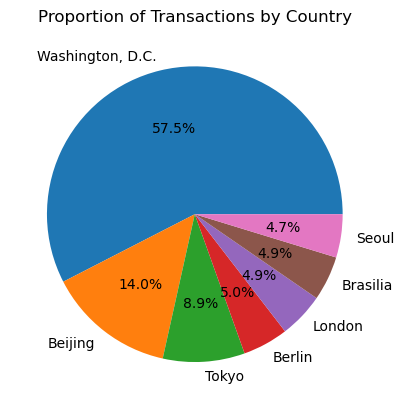

In [9]:
# Plotting Top 6 Countries with more than 100 flagged transxns:

filtered_country_counts.set_index("Country").plot(kind="pie", y="Number of Transactions", autopct="%1.1f%%", legend=False)
plt.ylabel('')
plt.title("Proportion of Transactions by Country")
plt.show()

In [10]:
#Analyze country vs transxns
most_popular_countries_df = final_df[final_df["Country"].isin(filtered_country_counts["Country"])]
most_popular_countries_df

,Transaction ID,IP,City,Lat,Lng,Continent,Capital,Country,Transaction Date and Time,Transaction Amount,...,Card Expiration Date,CVV Code (Hashed or Encrypted),Transaction Response Code,Fraud Flag or Label,Previous Transactions,Transaction Source,IP Address,Device Information,User Account Information,Transaction Notes
0,0003c9a2-3e18-499f-8b1f-f6f20eecb83c,11.133.155.94,Columbus,39.97883,-82.89573,North America,"Washington, D.C.","Washington, D.C.",2021-03-28 12:02:22,4584.73,...,NaT,162753c27c8b32975a0edf5e89ab4ed8e2f06f02a182e0...,0,1,3 or more,Online,11.133.155.94,Mobile,yuvraj-22,Culpa sit eligendi vel eaque aperiam quo. Sint...
3,001b0dd8-5d3b-401a-9093-2093b562e559,175.92.199.54,Beijing,39.90499,116.40529,Asia,Beijing,Beijing,2021-12-08 15:57:04,1077.20,...,1900-03-25,8b6cd7c429e83373dbd412f43d7422c0c4a127d93d0f2a...,12,1,3 or more,In-Person,175.92.199.54,Tablet,NaN,Qui quam ad ipsam ab atque ipsa. Qui tempore q...
6,004a7b0e-bb12-47f6-badd-4417365b0a77,129.61.18.255,Montgomery,32.40286,-86.24044,North America,"Washington, D.C.","Washington, D.C.",2022-04-21 21:00:04,2526.82,...,1900-07-29,f57b8252cea0e3cad78056cbf96b9fc041279769afd222...,0,1,NaN,Online,129.61.18.255,Tablet,NaN,Nisi sunt debitis atque dolore nisi aspernatur...
8,006692b3-4197-4362-a3f1-bbfc9102dcb7,126.212.60.151,Minato City,35.65521,139.76067,Asia,Tokyo,Tokyo,2020-01-16 17:42:08,497.63,...,NaT,87a4a78ecb6deb2dee9ddd0678d03800141864a049c99b...,5,1,1,In-Person,126.212.60.151,Desktop,zravi,Iste nisi neque voluptate. Rem maiores ipsa ma...
20,00dcd1e6-872b-4962-baf3-5678bee7a412,214.212.65.80,Columbus,39.97883,-82.89573,North America,"Washington, D.C.","Washington, D.C.",2020-04-24 16:53:23,3261.18,...,1900-10-24,459535faa370a3b5f8b87203b089623c7aeb9325abf241...,5,1,1,Online,214.212.65.80,Desktop,NaN,Quisquam saepe inventore consequuntur nisi dol...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7987,ff86600e-6a2b-4cda-9e81-53441976fd96,198.156.138.148,Richardson,32.98327,-96.70422,North America,"Washington, D.C.","Washington, D.C.",2020-06-23 08:18:46,2774.37,...,NaT,a2075145d3cc47b2b56aeec5e9c78fe7e0055169961b68...,0,1,1,In-Person,198.156.138.148,Desktop,NaN,Accusantium necessitatibus at mollitia velit. ...
7992,ffb7d51c-07f9-4ebc-a3c2-350df11b4079,179.126.159.240,Uberlândia,-18.91907,-48.27833,South America,Brasilia,Brasilia,2020-02-12 06:51:47,590.80,...,1900-03-26,58ec1b25c481b2c27fa032f9d266f05d5f77a9189f2942...,0,1,1,Online,179.126.159.240,Desktop,sahil81,Facilis voluptates possimus nisi atque id eos....
7993,ffce01f0-151b-4057-94d3-5f5f4a315919,34.204.62.67,North,37.45243,-76.41686,North America,"Washington, D.C.","Washington, D.C.",2022-06-15 23:40:25,3920.33,...,1900-11-26,64d095f2fecfdeb907dae5403b10966c4ae755b7598aa0...,0,1,1,Online,34.204.62.67,Desktop,NaN,Quod animi vero earum. Repudiandae labore recu...
7994,ffd383cc-4e8b-4001-81e6-bf87f6032f70,117.135.73.128,Shanghai,31.23171,121.47264,Asia,Beijing,Beijing,2022-02-13 14:44:06,3207.65,...,1900-08-27,02837c1944876b4fa860432c13f2d9b11a7fd94dae707c...,12,1,3 or more,In-Person,117.135.73.128,Desktop,NaN,Quasi ut nisi quos quos facilis. Facilis dolor...


In [11]:
# Exchange rates to USD (example rates, replace with actual rates)
exchange_rates = {
    "USD": 1.0,    # USD to USD
    "EUR": 1.2,    # 1 EUR = 1.2 USD
    "INR": 0.013   # 1 INR = 0.013 USD
}

# Function to convert amounts to USD
def convert_to_usd(amount, currency):
    return amount * round(exchange_rates[currency],2)

# Apply conversion to the dataframe
final_df["Amount in USD"] = final_df.apply(lambda row: convert_to_usd(row["Transaction Amount"], row["Transaction Currency"]), axis=1)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3989 entries, 0 to 7999
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Transaction ID                           3989 non-null   object        
 1   IP                                       3989 non-null   object        
 2   City                                     3980 non-null   object        
 3   Lat                                      3989 non-null   object        
 4   Lng                                      3989 non-null   object        
 5   Continent                                3989 non-null   object        
 6   Capital                                  3989 non-null   object        
 7   Country                                  3989 non-null   object        
 8   Transaction Date and Time                3989 non-null   datetime64[ns]
 9   Transaction Amount                       3989 

C:\Users\Srinika\AppData\Local\Temp\ipykernel_18400\2912348080.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["Amount in USD"] = final_df.apply(lambda row: convert_to_usd(row["Transaction Amount"], row["Transaction Currency"]), axis=1)


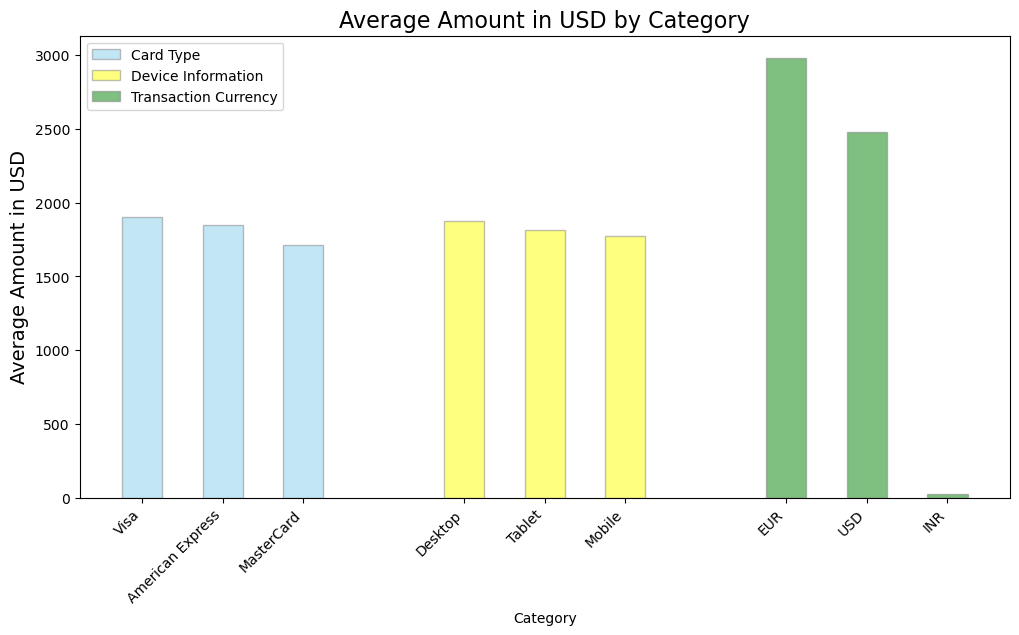

In [12]:
# Calculate the average transaction amount for each category and sort as per the provided parameters
card_type_avg = final_df.groupby("Card Type")["Amount in USD"].mean().sort_values(ascending=False).reset_index()
device_type_avg = final_df.groupby("Device Information")["Amount in USD"].mean().sort_values(ascending=False).reset_index()
currency_type_avg = final_df.groupby("Transaction Currency")["Amount in USD"].mean().sort_values(ascending=False).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width
bar_width = 0.5

# Set bar positions for each category with a small gap between categories
gap = 1
r1 = np.arange(len(card_type_avg))
r2 = np.arange(len(device_type_avg)) + len(card_type_avg) + gap
r3 = np.arange(len(currency_type_avg)) + len(card_type_avg) + len(device_type_avg) + 2 * gap

# Plot bars
bars1 = plt.bar(r1, card_type_avg["Amount in USD"], color="skyblue", width=bar_width, edgecolor="grey", label="Card Type", alpha=0.5)
bars2 = plt.bar(r2, device_type_avg["Amount in USD"], color="yellow", width=bar_width, edgecolor="grey", label="Device Information", alpha=0.5)
bars3 = plt.bar(r3, currency_type_avg["Amount in USD"], color="green", width=bar_width, edgecolor="grey", label="Transaction Currency", alpha=0.5)

# Add labels for x-axis
all_positions = list(r1) + list(r2) + list(r3)
all_labels = list(card_type_avg["Card Type"]) + list(device_type_avg["Device Information"]) + list(currency_type_avg["Transaction Currency"])

plt.xlabel("Category")
plt.xticks(all_positions, all_labels, rotation=45, ha='right')

# Adding titles and labels
plt.title("Average Amount in USD by Category", fontsize=16)
plt.ylabel("Average Amount in USD", fontsize=14)

# Adding a legend
plt.legend()


In [13]:
final_df.groupby("Transaction Currency")["Amount in USD"].sum()

Transaction Currency
EUR    3961408.524
INR      33289.486
USD    3271658.440
Name: Amount in USD, dtype: float64

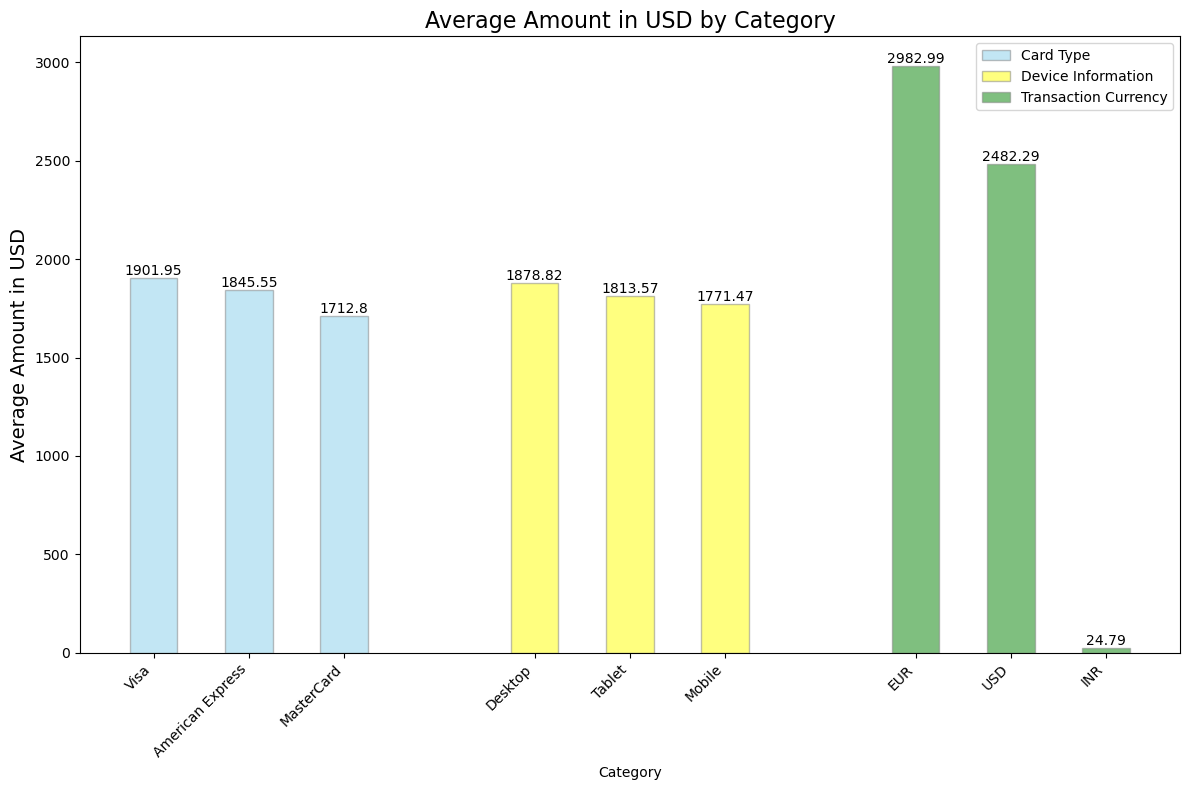

In [14]:
# Calculate the average transaction amount for each category and sort as per the provided parameters
card_type_avg = final_df.groupby("Card Type")["Amount in USD"].mean().sort_values(ascending=False).reset_index()
device_type_avg = final_df.groupby("Device Information")["Amount in USD"].mean().sort_values(ascending=False).reset_index()
currency_type_avg = final_df.groupby("Transaction Currency")["Amount in USD"].mean().sort_values(ascending=False).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Bar width
bar_width = 0.5

# Set bar positions for each category with a small gap between categories
gap = 1
r1 = np.arange(len(card_type_avg))
r2 = np.arange(len(device_type_avg)) + len(card_type_avg) + gap
r3 = np.arange(len(currency_type_avg)) + len(card_type_avg) + len(device_type_avg) + 2 * gap

# Plot bars
bars1 = plt.bar(r1, card_type_avg["Amount in USD"], color="skyblue", width=bar_width, edgecolor="grey", label="Card Type", alpha=0.5)
bars2 = plt.bar(r2, device_type_avg["Amount in USD"], color="yellow", width=bar_width, edgecolor="grey", label="Device Information", alpha=0.5)
bars3 = plt.bar(r3, currency_type_avg["Amount in USD"], color="green", width=bar_width, edgecolor="grey", label="Transaction Currency", alpha=0.5)

# Add labels for x-axis
all_positions = list(r1) + list(r2) + list(r3)
all_labels = list(card_type_avg["Card Type"]) + list(device_type_avg["Device Information"]) + list(currency_type_avg["Transaction Currency"])

plt.xlabel("Category")
plt.xticks(all_positions, all_labels, rotation=45, ha='right')

# Adding titles and labels
plt.title("Average Amount in USD by Category", fontsize=16)
plt.ylabel("Average Amount in USD", fontsize=14)

# Adding a legend
plt.legend()

# Adding text labels inside the bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()

# Show the plot
plt.show()

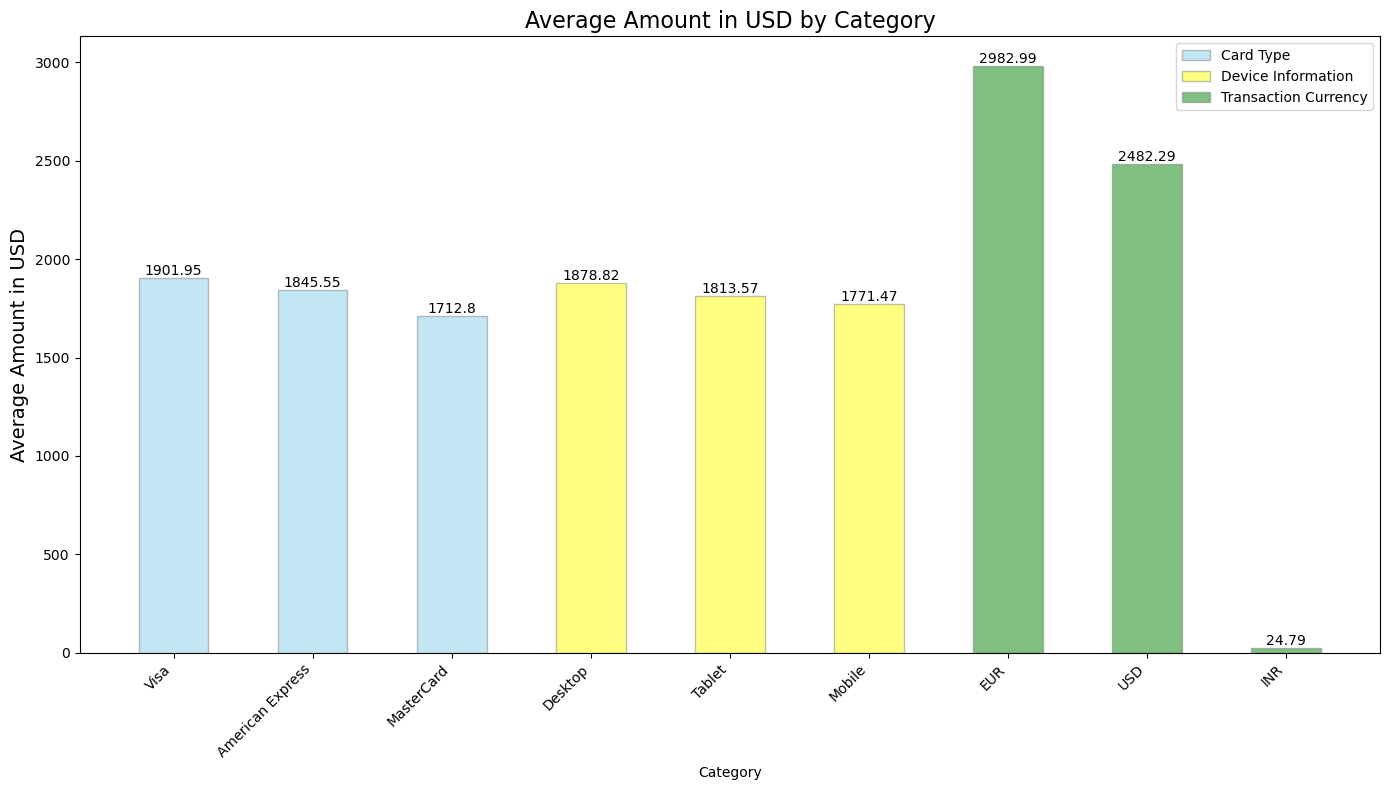

In [15]:
# Calculate the average transaction amount for each category and sort as per the provided parameters
card_type_avg = final_df.groupby("Card Type")["Amount in USD"].mean().sort_values(ascending=False).reset_index()
device_type_avg = final_df.groupby("Device Information")["Amount in USD"].mean().sort_values(ascending=False).reset_index()
currency_type_avg = final_df.groupby("Transaction Currency")["Amount in USD"].mean().sort_values(ascending=False).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Bar width
bar_width = 0.5

# Set bar positions for each category
r1 = np.arange(len(card_type_avg))
r2 = r1 + len(card_type_avg)
r3 = r2 + len(device_type_avg)

# Plot bars
bars1 = plt.bar(r1, card_type_avg["Amount in USD"], color="skyblue", width=bar_width, edgecolor="grey", label="Card Type", alpha=0.5)
bars2 = plt.bar(r2, device_type_avg["Amount in USD"], color="yellow", width=bar_width, edgecolor="grey", label="Device Information", alpha=0.5)
bars3 = plt.bar(r3, currency_type_avg["Amount in USD"], color="green", width=bar_width, edgecolor="grey", label="Transaction Currency", alpha=0.5)

# Add labels for x-axis
all_positions = list(r1) + list(r2) + list(r3)
all_labels = list(card_type_avg["Card Type"]) + list(device_type_avg["Device Information"]) + list(currency_type_avg["Transaction Currency"])

plt.xlabel("Category")
plt.xticks(all_positions, all_labels, rotation=45, ha='right')

# Adding titles and labels
plt.title("Average Amount in USD by Category", fontsize=16)
plt.ylabel("Average Amount in USD", fontsize=14)

# Adding a legend
plt.legend()

# Adding text labels inside the bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()

# Show the plot
plt.show()

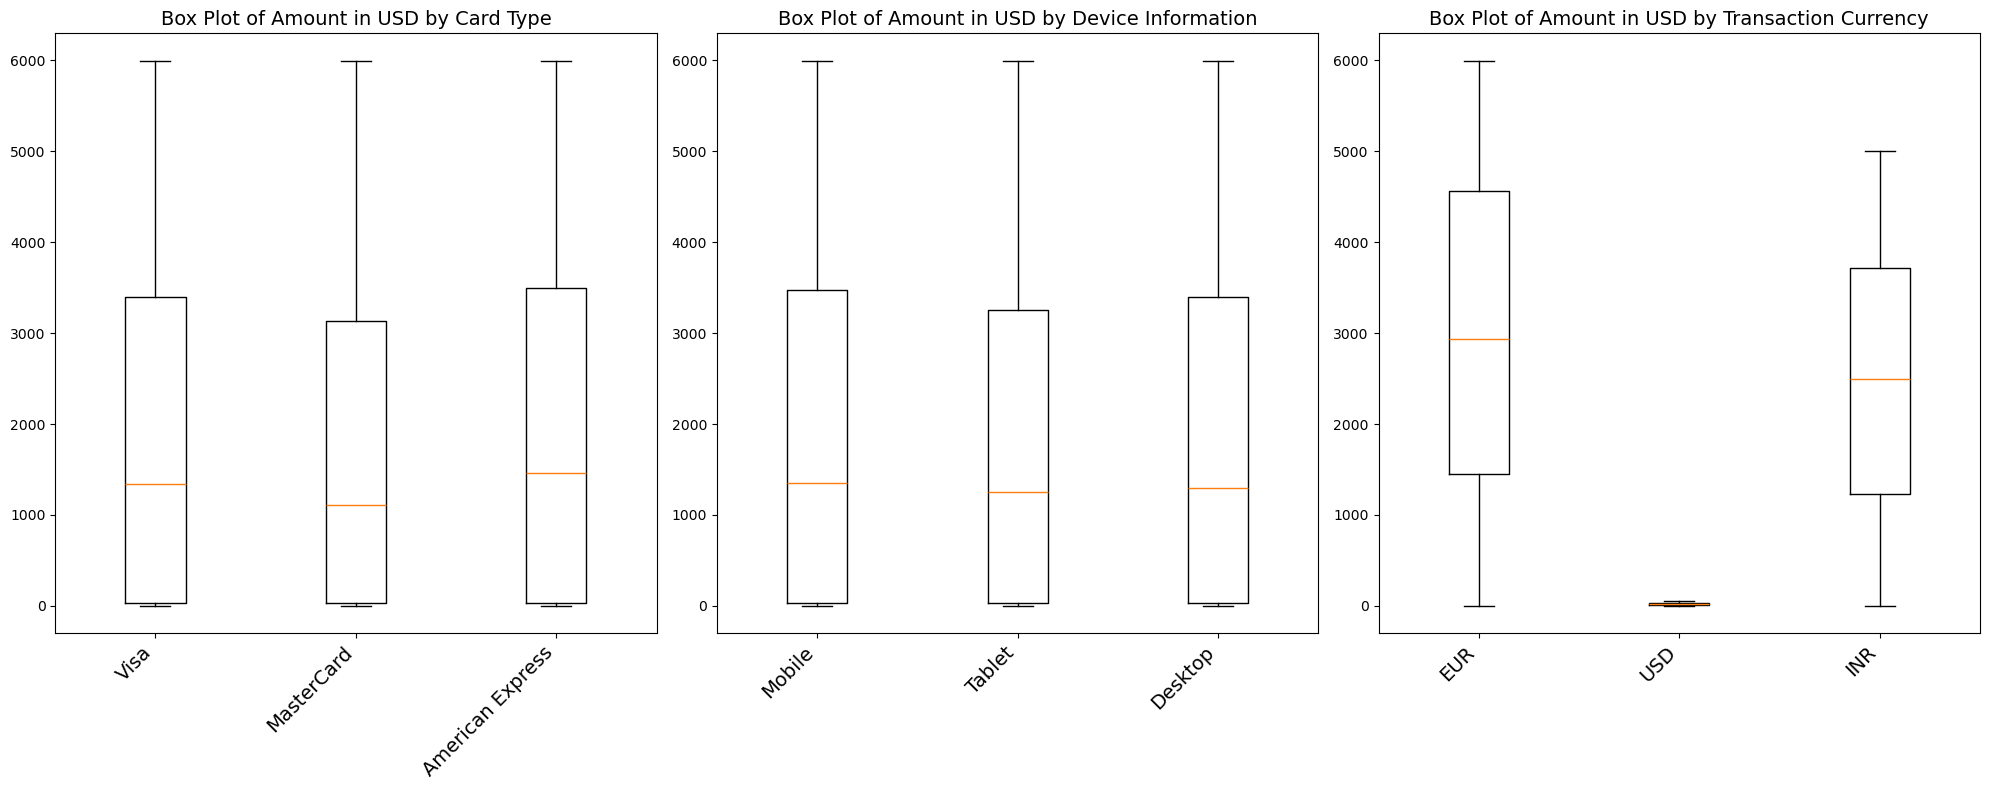

In [16]:
#Creating subplots for 3 categories vs transxn amount
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Box Plot for Card Type
axes[0].boxplot([group["Amount in USD"].values for name, group in final_df.groupby('Card Type')])
axes[0].set_title('Box Plot of Amount in USD by Card Type',fontsize=14)
axes[0].set_xticklabels(final_df['Card Type'].unique(), rotation=45, ha='right',fontsize=14)

# Box Plot for Device Information
axes[1].boxplot([group["Amount in USD"].values for name, group in final_df.groupby('Device Information')])
axes[1].set_title('Box Plot of Amount in USD by Device Information',fontsize=14)
axes[1].set_xticklabels(final_df['Device Information'].unique(), rotation=45, ha='right',fontsize=14)

# Box Plot for Transaction Currency
axes[2].boxplot([group["Amount in USD"].values for name, group in final_df.groupby('Transaction Currency')])
axes[2].set_title('Box Plot of Amount in USD by Transaction Currency',fontsize=14)
axes[2].set_xticklabels(final_df['Transaction Currency'].unique(), rotation=45, ha='right',fontsize=14)

plt.tight_layout()
plt.show()

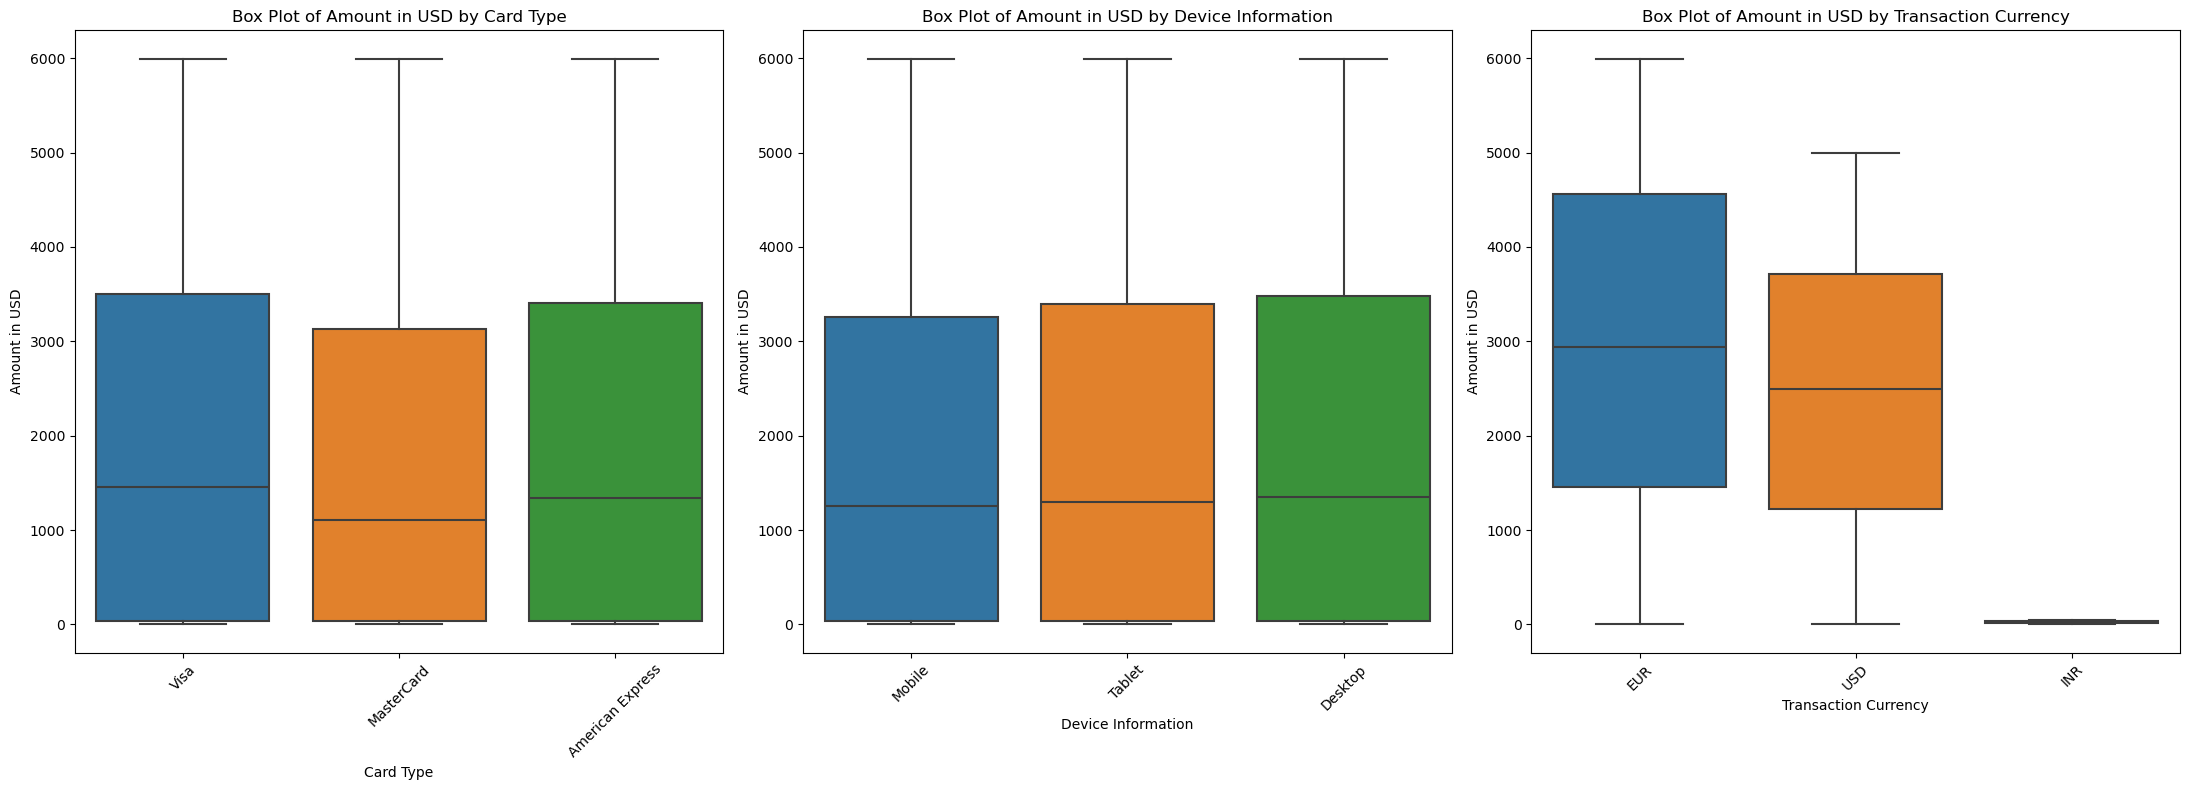

In [17]:
plt.figure(figsize=(22, 8))

# Box plot for Card Type
plt.subplot(1, 3, 1)
sns.boxplot(data=final_df, x='Card Type', y='Amount in USD')
plt.title('Box Plot of Amount in USD by Card Type')
plt.xticks(rotation=45)

# Box plot for Device Information
plt.subplot(1, 3, 2)
sns.boxplot(data=final_df, x='Device Information', y='Amount in USD')
plt.title('Box Plot of Amount in USD by Device Information')
plt.xticks(rotation=45)

# Box plot for Transaction Currency
plt.subplot(1, 3, 3)
sns.boxplot(data=final_df, x='Transaction Currency', y='Amount in USD')
plt.title('Box Plot of Amount in USD by Transaction Currency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [18]:


# Perform ANOVA using statsmodels
# Combine all categorical columns into a long format for ANOVA
df_long = pd.melt(final_df, id_vars=['Amount in USD'], value_vars=['Card Type', 'Device Information', 'Transaction Currency'],
                  var_name='Category', value_name='Type')

# Perform ANOVA using statsmodels
model = ols('Q("Amount in USD") ~ C(Type)', data=df_long).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Perform ANOVA using scipy.stats (for each category separately)
card_type_anova = f_oneway(*[group["Amount in USD"].values for name, group in final_df.groupby('Card Type')])
device_type_anova = f_oneway(*[group["Amount in USD"].values for name, group in final_df.groupby('Device Information')])
currency_type_anova = f_oneway(*[group["Amount in USD"].values for name, group in final_df.groupby('Transaction Currency')])

print("ANOVA results for Card Type:", card_type_anova)
print("ANOVA results for Device Information:", device_type_anova)
print("ANOVA results for Transaction Currency:", currency_type_anova)

                sum_sq       df           F  PR(>F)
C(Type)   6.735368e+09      8.0  296.235843     0.0
Residual  3.398539e+10  11958.0         NaN     NaN
ANOVA results for Card Type: F_onewayResult(statistic=3.6837999050157655, pvalue=0.02521289817212182)
ANOVA results for Device Information: F_onewayResult(statistic=1.1523363263123125, pvalue=0.31600307989524856)
ANOVA results for Transaction Currency: F_onewayResult(statistic=1944.0899078049017, pvalue=0.0)


ANOVA Results Interpretation:
Card Type:


p-value: 0.025
Interpretation:

The p-value (0.025) is less than the typical significance level of 0.05, indicating that there are statistically significant differences in the average transaction amounts across different Card Types.

Device Information:
p-value: 0.316
Interpretation:

The p-value (0.316) is greater than 0.05, indicating that there is no statistically significant difference in the average transaction amounts across different Device Information categories.


Transaction Currency:
p-value: 0.0
Interpretation:

The p-value (0.0) is much less than 0.05, indicating a highly significant difference in the average transaction amounts across different Transaction Currencies.

Conclusion:
Card Type: There are significant differences in average transaction         amounts between different card types.

Device Information: There are no significant differences in average transaction amounts between different device types.

Transaction Currency: There are highly significant differences in average transaction amounts between different currencies.

In [19]:
source_counts = final_df["Transaction Source"].value_counts()
source_counts

Transaction Source
In-Person    2024
Online       1965
Name: count, dtype: int64

Interpretation:

The data shows a nearly even split between In-Person and Online transactions.
In-Person transactions are slightly higher by a margin of 59 transactions.

In [20]:
#Accessing Merchant Category Codes and thier occurences
mcc_counts =final_df["Merchant Category Code (MCC)"].value_counts()
mcc_counts=mcc_counts.reset_index()
mcc_counts.columns=["Mcc","Counts"]
filtered_mcc=mcc_counts.loc[mcc_counts["Counts"]==4]
#Providing description to the MCC
bins = [0, 1500, 3000, 3300, 3500, 4000, 4800, 5000, 5700, 7300, 8000, 9000, 10000]
descriptions = [
    "Agricultural services",
    "Contracted services",
    "Airlines",
    "Car rentals",
    "Lodging",
    "Transportation services",
    "Utility services",
    "Retail outlet services",
    "Miscellaneous stores",
    "Business services",
    "Professional services and membership organizations",
    "Government services"
]
#Adding Description column to MCC
final_mcc = filtered_mcc.copy()
final_mcc.loc[:, "Description"] = pd.cut(filtered_mcc["Mcc"], bins, labels=descriptions, include_lowest=True)
final_mcc
#Filtering MCC codes with max occurence of 4
grouped_df = final_mcc.groupby('Description',observed=True)["Counts"].sum().reset_index()
filtered_df = grouped_df[grouped_df['Counts'] >= 4]
#Sorting MCC by their number of occurences
filtered_df = filtered_df.reset_index(drop=True).sort_values(by='Counts', ascending=False)
print(filtered_df.to_string(index=False))

          Description  Counts
  Government services      20
 Miscellaneous stores      12
Agricultural services       8
  Contracted services       4
          Car rentals       4
              Lodging       4


Analysis on Merchant Category Codes:


The categories most frequently flagged are Government services, Miscellaneous stores, and Agricultural services.
